# Introduction

Based on the narrative on Injury Reports, the goal of this notebook is to process the information and train well-perfomenced models able to predict the following attributes based on the narrative:

<div><ul><li> Source </li><li> Event </li><li> Amputation </li><li> Body Part </li><li> Contractor </li><li> Hospitalization </li><li> Nature </li></ul></div>

In this case, the narrative is the predictor variable. The following sections are implemented base on the following flow chart. 
<img src="2020-04-05.png"></img>






<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li></ul></li><li><span><a href="#Analysis/Modeling" data-toc-modified-id="Analysis/Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis/Modeling</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span></li>

### Imports


In [1]:
import pandas as pd  #Data Manipulation
import numpy as np  #Linear Algebra
import sklearn   #Machine Learning models



'''Natural Language Processing libraries'''
import nltk 
import gensim
import regex as re
import spacy
from spacy.lang.en import English
from nltk.tokenize import word_tokenize 
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
import re, string, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from gensim.models import FastText
from gensim.models import Word2Vec

'''Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style 
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

init_notebook_mode(connected=True)
nltk.download('maxent_ne_chunker')
nltk.download('words')

%matplotlib inline

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\afabi/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\afabi/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Text Pre-processing



In [5]:
reports = pd.read_csv("Source.csv", encoding= 'unicode_escape')

reports.head()

,ID,Final_Narrative,source
0,2015010029,Two employees in a scissor lift were wrecking ...,structures and surfaces
1,2015010037,"On Friday, January 2, 2015, at 10:30 p.m., a c...",parts and materials
2,2015010043,While in the process of unloading pre-tied mat...,parts and materials
3,2015010068,Employee was loading plastic pipes onto a util...,parts and materials
4,2015010073,A fire suppression system inadvertently went o...,"tools, instruments, and equipment"


In [6]:
# Text pre-processing: applying lambda functions to remove special characters and lowercase the narratives applying regex library. 

reports["Final_Narrative"] = reports["Final_Narrative"].map(lambda x: re.sub('\^,?#=*\]', '', x))
reports["Final_Narrative"] = reports["Final_Narrative"].map(lambda x: x.lower())

reports.head()

,ID,Final_Narrative,source
0,2015010029,two employees in a scissor lift were wrecking ...,structures and surfaces
1,2015010037,"on friday, january 2, 2015, at 10:30 p.m., a c...",parts and materials
2,2015010043,while in the process of unloading pre-tied mat...,parts and materials
3,2015010068,employee was loading plastic pipes onto a util...,parts and materials
4,2015010073,a fire suppression system inadvertently went o...,"tools, instruments, and equipment"


## Document class

The Document class retrieves a DataFrame with the respective narratives and labels. It stores the original DataFrame and add new columns with the pre-processed and cleaned text.

In [46]:
class Document:
    """ Retrieve the narratives from the DataFrame and respectively
        store and pre-process it. 
        
        :param df: DataFrame including the reports and the predictor variable. 
        
        
        :ivar data: Stores the DataFrame.
        :ivar text: Stores the narratives as string.
        :ivar corpus: Stores the pre-processed text.
    """
    
    
    def __init__(self, df):
        self.data = df
        self.text = df["Final_Narrative"].astype(str)
        self.textPreProcessing()
        
        
    def remove_non_ascii(self, words):
        """Remove non-ASCII characters from list of tokenized words
        
        :param words:  List of words to be transformed when removing non_ascii characters.
        
        :return new_words: List of words after the transformation of removed non_ascii characters.
        
        """
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def remove_punctuation(self, words):
        """Remove punctuation from list of tokenized words
        
        :param words:  List of words that will get remove their punctuations, if any. 
        
        :return new_words: List of transformed words.
        
        
        """
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def stem_words(self, words):
        """Stem words in list of tokenized words
        
        :param words:  List of words to be processed. 
        
        :return new_words: List of the received words respective stems.
        
        
        """
        
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    def lemmatize_verbs(self, words):
        """Lemmatize verbs in list of tokenized words
        
        :param words:  List of words to be processed. 
        
        :return new_words: List of the received words respective lemmas.
        
        """
        
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    def remove_stopwords(self, words):
         """Remove common words that have no meaning or importance in the sentence.
        
        :param words:  List of words to be processed and get stop words removed.. 
        
        :return new_words: List of words with the stop words already removed.
        
        """
        
        stop_words = set(stopwords.words('english')) 
        
        for word in stop_words:
            if word in words:
                words.remove(word)
                
        return words


    def normalize(self, words):
        words = self.remove_non_ascii(words)
        words = self.remove_stopwords(words)
        words = self.remove_punctuation(words)
        words = self.lemmatize_verbs(words)
        return words
    
    
    def textPreProcessing(self):
         """Pre-process the text, normalize and clean it.
            The function stores the cleaned text in the self.data
            attribute. """

        clean_text = []

        for narrative in self.text:
            tokenized_sentences = []
            narrative = sent_tokenize(narrative)
            for sentence in narrative:
                sentence = word_tokenize(sentence)
                sentence = self.normalize(sentence)
                tokenized_sentences.append(sentence)
            clean_text.append(tokenized_sentences)
            
            
                    
        print(len(self.text), len(clean_text))
        self.data["clean_text"] = clean_text
        

In [87]:
narratives_doc = Document(reports)
narratives_doc.data.head()

8143 8143


,ID,Final_Narrative,source,clean_text,label_num
0,2015010029,two employees in a scissor lift were wrecking ...,structures and surfaces,"[[two, employees, scissor, lift, wreck, form, ...",6
1,2015010037,"on friday, january 2, 2015, at 10:30 p.m., a c...",parts and materials,"[[friday, january, 2, 2015, 1030, pm, crew, em...",4
2,2015010043,while in the process of unloading pre-tied mat...,parts and materials,"[[process, unload, pretied, mat, of, rebar, on...",4
3,2015010068,employee was loading plastic pipes onto a util...,parts and materials,"[[employee, load, plastic, pip, onto, utility,...",4
4,2015010073,a fire suppression system inadvertently went o...,"tools, instruments, and equipment","[[fire, suppression, system, inadvertently, go...",7


# Word Embeddings

Once the text is pre-processed and cleaned, we proceed to train word embeddings. The default embedding used is TD-IDF as I thought that would be the most convenient for the approach, but Word2Vec and FastText works pretty well too in aspects of perfomance. 

In [ ]:
from gensim.models import FastText
from gensim.models import Word2Vec


fast_text_model = FastText(narratives_doc.data["clean_text"], min_count=2, workers=50, window=2, word_ngrams=1, alpha=0.02, hs=1)

fast_text_model.train(narratives_doc.data["clean_text"], epochs=20, total_examples=fast_text_model.corpus_count, compute_loss=True)

In [ ]:
word2vec_model = Word2Vec(narratives_doc.data["clean_text"], min_count=2, workers=20, window=2, word_ngrams=1, alpha=0.02, hs=1)
corpus.reverse()
word2vec_model.train(narratives_doc.data["clean_text"], epochs=20, total_examples=model.corpus_count, compute_loss=True)

In [74]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(narratives_doc.data['clean_text'].astype('str')) #features



lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

LE = LabelEncoder()
narratives_doc.data['label_num'] = LE.fit_transform(narratives_doc.data['source'])

y = narratives_doc.data['label_num'].values

X = lsa.fit_transform(X)
X.shape


(8143, 100)

# Analysis/Modeling

Now it is time to implement the respective models. First, we start with a model dictionary to check which models perform better with the default parameters. Based on their perfomance, we choose the models that we think could work better for our approach once we adjust the respective parameters.

## Models evaluation with default parameters



In [75]:
#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

c:\users\afabi\pycharmprojects\datamining\venv\lib\site-packages\sklearn\dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.

c:\users\afabi\pycharmprojects\datamining\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\afabi\pycharmprojects\datamining\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,model_name,accuracy_score,precision_score,recall_score,f1_score
5,Gaussian Naive Bayes,0.577569,0.516519,0.536061,0.49491
2,Random Forest,0.67458,0.638345,0.477565,0.494264
6,K Nearest Neighbor,0.604585,0.48812,0.500851,0.482038
1,Stochastic Gradient Descent,0.692591,0.527607,0.463611,0.470355
4,AdaBoost,0.537454,0.425025,0.411708,0.414207
3,Decsision Tree,0.519034,0.379906,0.385644,0.382389
0,Dummy,0.171101,0.105166,0.104917,0.104949


## Stochastic Gradient Descent Hyperparameter tuning

In [52]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 53.3min finished


## Random Forest Hyperparameter Tuning

In [53]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 231.5min finished


In [ ]:
gridsearch.best_params_  # Change the parameters based on the application

In [54]:
# Define the best models with the selected params from the grdsearch
# Gridsearch was done on a virtual machine outisde of this notebook
# Normally you can just say 'best_model = gridsearch.best_params_' 
# to use the best parameters from the gridsearch

sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 2000,
                                       random_state=3)



In [95]:
gridsearch.best_params_  # Change the parameters based on the application

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 2000,
 'random_state': 3}

## Stochastic Gradient Descent

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]]


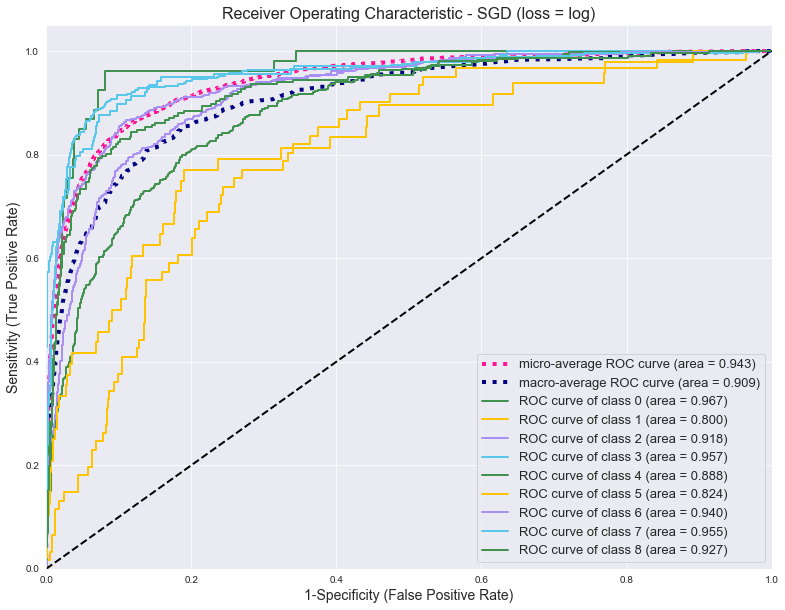

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[6 4 4 ... 6 6 4]


In [78]:
import itertools
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
print(y_test_b)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = itertools.cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

### Confusion Matrix

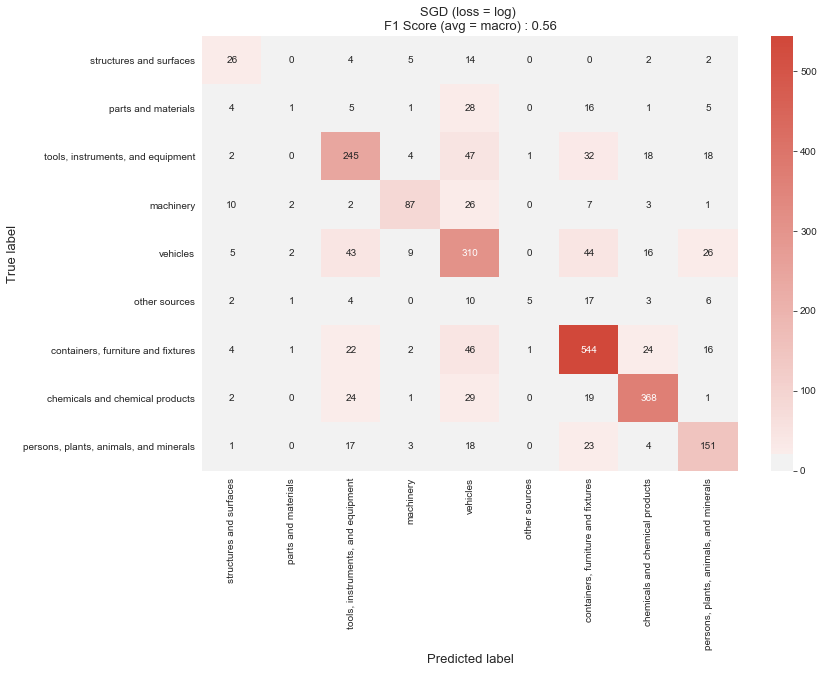

In [80]:
#Confusion Matrix - SGD

#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['structures and surfaces','parts and materials','tools, instruments, and equipment', 'machinery', 'vehicles', 
                              'other sources', 'containers, furniture and fixtures', 'chemicals and chemical products', 'persons, plants, animals, and minerals'], 
                     columns = ['structures and surfaces','parts and materials','tools, instruments, and equipment', 'machinery', 'vehicles', 
                              'other sources', 'containers, furniture and fixtures', 'chemicals and chemical products', 'persons, plants, animals, and minerals'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Random Forest

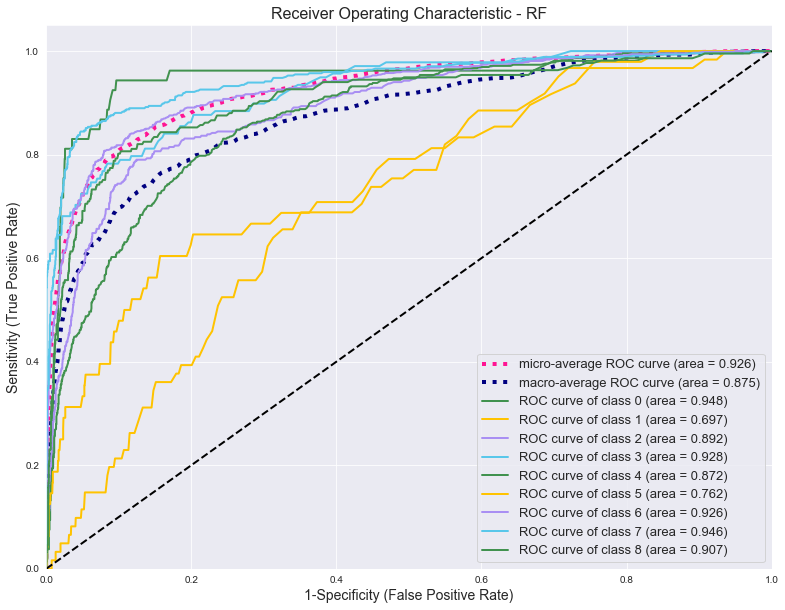

In [83]:
#Plot AUC - RF

#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = itertools.cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

### RF Confusion Matrix

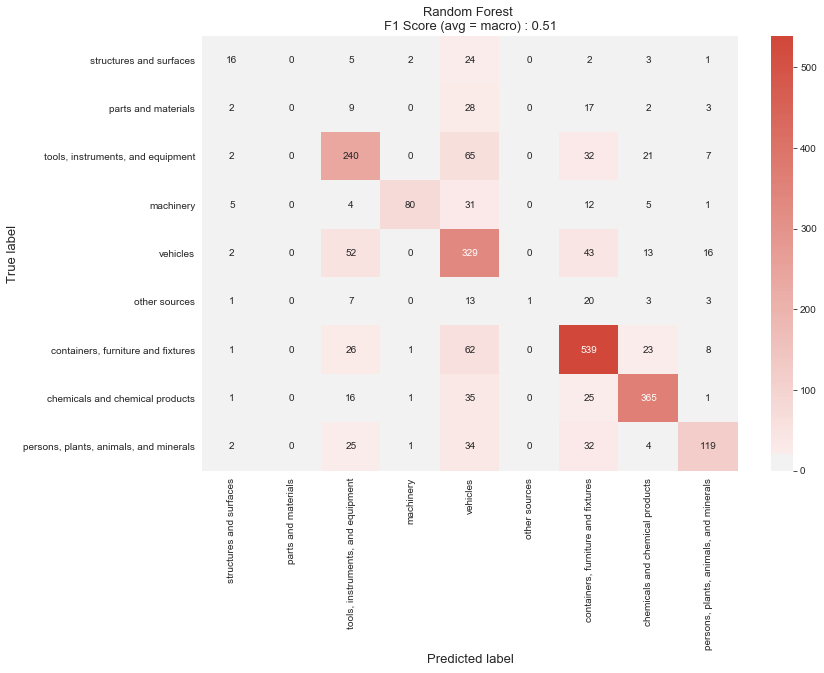

In [84]:
#Confusion Matrix - RF

#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['structures and surfaces','parts and materials','tools, instruments, and equipment', 'machinery', 'vehicles', 
                              'other sources', 'containers, furniture and fixtures', 'chemicals and chemical products', 'persons, plants, animals, and minerals'], 
                     columns = ['structures and surfaces','parts and materials','tools, instruments, and equipment', 'machinery', 'vehicles', 
                              'other sources', 'containers, furniture and fixtures', 'chemicals and chemical products', 'persons, plants, animals, and minerals'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

# Results

This section serves to predict unlabeled information. Clean the text with the Document class, pass it to the TD-IDF vectorizer and transformed it. For another DataSets, it will be necessary to manually adjust the labels_num dictionary. 

In [90]:
LE.classes_


array(['chemicals and chemical products',
       'containers, furniture and fixtures', 'machinery', 'other sources',
       'parts and materials', 'persons, plants, animals, and minerals',
       'structures and surfaces', 'tools, instruments, and equipment',
       'vehicles'], dtype=object)

In [92]:
# Creating the features (tf-idf weights) for the processed text

texts = narratives_doc.data['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = narratives_doc.data['label_num'].values #target

# Dimenionality reduction. Only using the 100 best features
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


df_holdout = reports.copy()

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X)
df_holdout['pred_rf'] = rf_best_model.predict(X)

label_num_dict = {'structures and surfaces': 6,'parts and materials': 4,'tools, instruments, and equipment': 7, 'machinery': 2, 
                  'vehicles' : 8, 'other sources': 3, 'containers, furniture and fixtures': 1, 'chemicals and chemical products' : 0, 
                  'persons, plants, animals, and minerals': 5}

df_holdout['correct'] = df_holdout['source'].map(label_num_dict)
df_holdout = df_holdout[['Final_Narrative', 'source', 'pred_sgd', 'pred_rf', 'correct']]

In [94]:
df_holdout.head(20)

,Final_Narrative,source,pred_sgd,pred_rf,correct
0,two employees in a scissor lift were wrecking ...,structures and surfaces,6,6,6
1,"on friday, january 2, 2015, at 10:30 p.m., a c...",parts and materials,6,4,4
2,while in the process of unloading pre-tied mat...,parts and materials,6,4,4
3,employee was loading plastic pipes onto a util...,parts and materials,4,4,4
4,a fire suppression system inadvertently went o...,"tools, instruments, and equipment",7,7,7
5,a worker was installing a retaining wall next ...,"persons, plants, animals, and minerals",6,5,5
6,a roofer slipped on the ridge of a roof while ...,parts and materials,6,4,4
7,"on monday, january 5, 2014, an employee slippe...","persons, plants, animals, and minerals",6,5,5
8,a stack of 12 x 4 foot panels of sheet rock in...,parts and materials,4,4,4
9,employees were moving equipment into the trail...,parts and materials,6,4,4
